In [1]:
import os
nthreads = 10
os.environ["OMP_NUM_THREADS"] = str(nthreads)
os.environ["OPENBLAS_NUM_THREADS"] = str(nthreads)
os.environ["MKL_NUM_THREADS"] = str(nthreads)

In [2]:
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.interpolate import griddata, RBFInterpolator, NearestNDInterpolator, LinearNDInterpolator, RegularGridInterpolator

In [3]:
%config InlineBackend.figure_format = 'retina'

In [4]:
import inferagni as ia

In [5]:
datadir = "../src/inferagni/data/"
gr = ia.grid.Grid(datadir)

Loading data from CSV files...
Data directory: ../src/inferagni/data/
Grid size: 264600
Input change counts: {'frac_atm': 264599, 'frac_core': 37799, 'mass_tot': 12599, 'logCO': 839, 'logZ': 209, 'instellation': 29, 'Teff': 5}
Input vars:  ['Teff', 'instellation', 'logZ', 'logCO', 'mass_tot', 'frac_core', 'frac_atm']
Output vars: ['succ', 'flux_loss', 'r_bound', 'p_surf', 't_surf', 'r_surf', 'μ_surf', 'g_surf', 't_phot', 'r_phot', 'μ_phot', 'g_phot', 'vmr_H2', 'vmr_H2O', 'vmr_CO2', 'vmr_CO', 'vmr_O2', 'vmr_OH', 'vmr_NH3', 'vmr_NO2', 'vmr_N2', 'vmr_SO2', 'vmr_H2S', 'vmr_H2SO4', 'Kzz_max', 'conv_ptop', 'conv_pbot']
Loaded data


In [6]:
gr.show_inputs();

Teff        
	- [2500. 3150. 3800. 4450. 5100. 5750.]
instellation
	- [   1.   10.  100.  300. 1000.]
logZ        
	- [-2.  -1.5 -1.  -0.5  0.   0.5  1. ]
logCO       
	- [-3. -2. -1.  0.]
mass_tot    
	- [ 1.     1.24   1.537  1.905  2.362  2.928  3.63   4.5    5.044  5.653
  6.336  7.102  7.96   8.922 10.   ]
frac_core   
	- [0.2   0.325 0.7  ]
frac_atm    
	- [0.001   0.00251 0.0063  0.0158  0.0397  0.0996  0.25   ]


In [7]:
print(gr.get_points())

[array([2500., 3150., 3800., 4450., 5100., 5750.]), array([1000.,  300.,  100.,   10.,    1.]), array([ 1. ,  0.5,  0. , -0.5, -1. , -1.5, -2. ]), array([-3., -2., -1.,  0.]), array([10.   ,  8.922,  7.96 ,  7.102,  6.336,  5.653,  5.044,  4.5  ,
        3.63 ,  2.928,  2.362,  1.905,  1.537,  1.24 ,  1.   ]), array([0.2  , 0.325, 0.7  ]), array([0.001  , 0.00251, 0.0063 , 0.0158 , 0.0397 , 0.0996 , 0.25   ])]


Plot instellation, frac_atm
Filter by logZ = 0.5
Filter by logCO = -1
Filter by frac_core = 0.325
Filter by Teff = 4450
Number of points: 500
vmin:1.0    vmax:1000.0


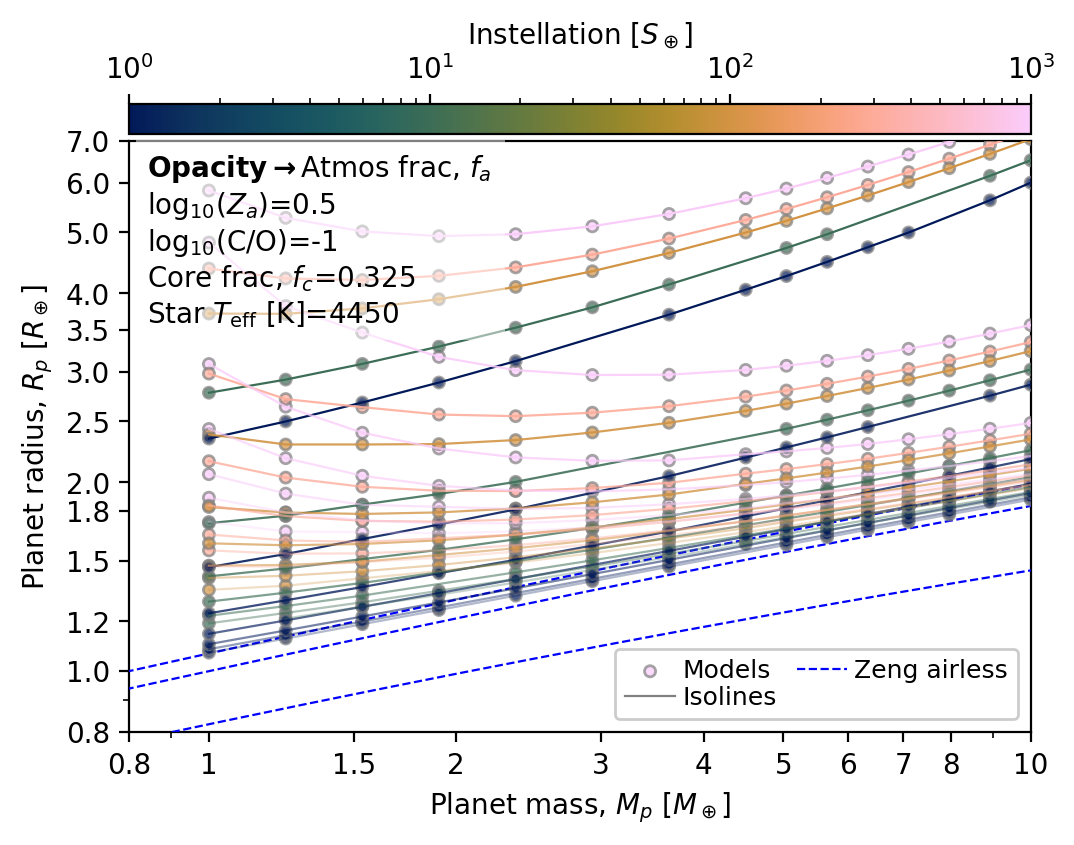

In [8]:
opts = {
    "key1"    : "instellation",
    "key2"    : "frac_atm",
    "controls": {"logZ":0.5, "logCO":-1,  "frac_core":0.325, "Teff":4450},
    "show_scatter" : True,
    "show_isolines" : True,
}

fig = ia.plot.massrad_2d(gr, **opts)
plt.show(fig)

Filter by frac_atm = 0.0063
Filter by frac_core = 0.325
Filter by logZ = 0
Filter by Teff = 4450
Filter by logCO = -1
Number of points: 74
x range: 1.00 - 10.00
y range: 1.29 - 6.12


/tmp/ipykernel_902/384511466.py:12: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  fig.colorbar(sm, label=ia.util.varprops[zkey].label).ax.set_yscale("log")


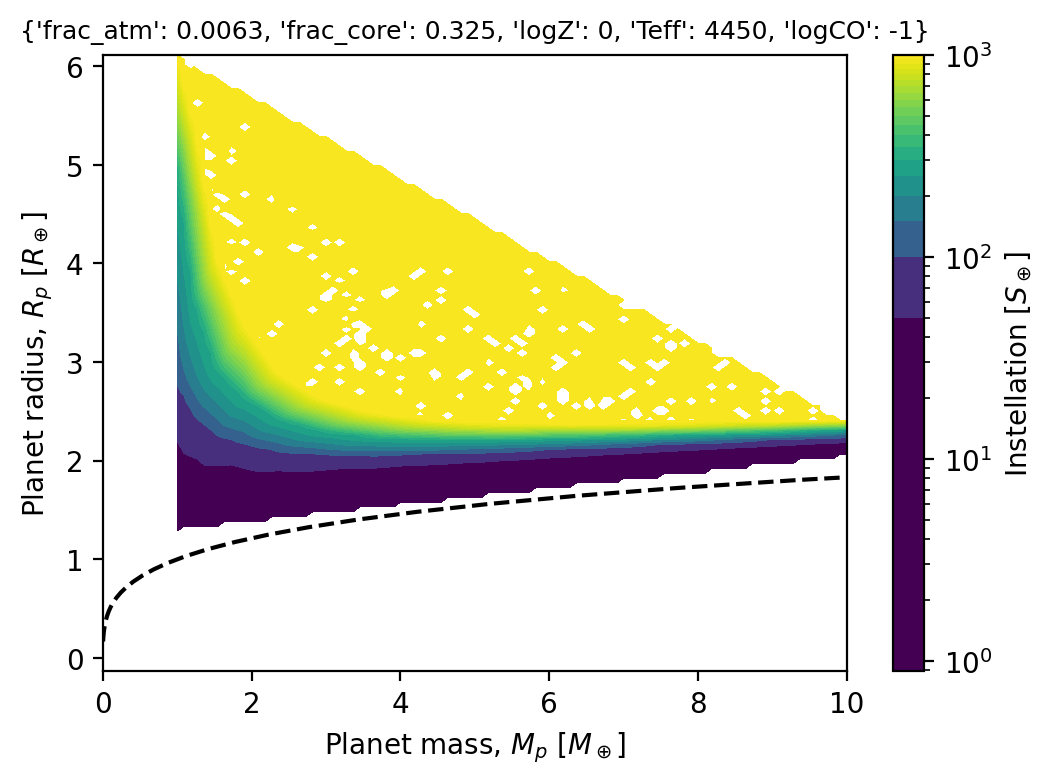

Filter by frac_core = 0.325
Filter by logZ = 0.0
Filter by instellation = 10.0
Filter by Teff = 4450
Filter by logCO = -1
Number of points: 97
x range: 1.00 - 10.00
y range: 1.49 - 12.65


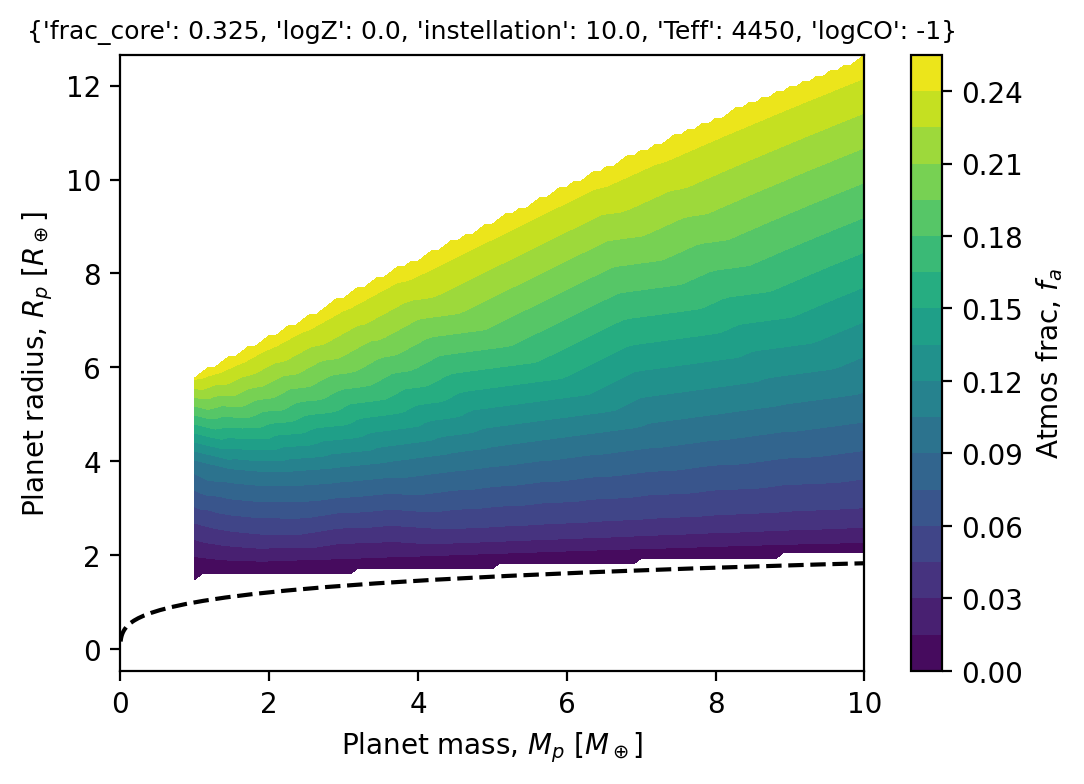

In [9]:
zkey = "instellation"
controls =  {"frac_atm":0.0063, "frac_core":0.325, "logZ":0, "Teff":4450, "logCO":-1}
itp_x, itp_y, itp_z = gr.interp_2d(controls=controls,
                                     zkey=zkey,
                                     resolution=100, method='linear')

fig,ax = plt.subplots(1,1,figsize=(6,4))
sm = ax.contourf(itp_x, itp_y, itp_z, levels=20, cmap='viridis', norm='log')
ax.plot(ia.plot.zeng[0.325][0],ia.plot.zeng[0.325][1], c='k', ls='--', label="Zeng+2019")
ax.set(xlabel=ia.util.varprops["mass_tot"].label, ylabel=ia.util.varprops["r_phot"].label, xlim=(0,10))
ax.set_title(f"{controls}", fontsize=9)
fig.colorbar(sm, label=ia.util.varprops[zkey].label).ax.set_yscale("log")
plt.show(fig)


zkey = "frac_atm"
controls={"frac_core":0.325, "logZ":0.0, "instellation":10.0, "Teff":4450, "logCO":-1}
itp_x, itp_y, itp_z = gr.interp_2d(controls=controls,
                                     zkey=zkey,
                                     resolution=100, method='linear')

fig,ax = plt.subplots(1,1,figsize=(6,4))
sm = ax.contourf(itp_x, itp_y, itp_z, levels=20, cmap='viridis')
ax.plot(ia.plot.zeng[0.325][0],ia.plot.zeng[0.325][1], c='k', ls='--', label="Zeng+2019")
ax.set(xlabel=ia.util.varprops["mass_tot"].label, ylabel=ia.util.varprops["r_phot"].label, xlim=(0,10))
ax.set_title(f"{controls}", fontsize=9)
fig.colorbar(sm, label=ia.util.varprops[zkey].label)
plt.show(fig)

In [10]:
gr.interp_init(vkey="r_phot")

Organise interpolator input data:
	Teff
		[2500. 3150. 3800. 4450. 5100. 5750.]
	instellation
		[1000.  300.  100.   10.    1.]
	logZ
		[ 1.   0.5  0.  -0.5 -1.  -1.5 -2. ]
	logCO
		[-3. -2. -1.  0.]
	mass_tot
		[10.     8.922  7.96   7.102  6.336  5.653  5.044  4.5    3.63   2.928
  2.362  1.905  1.537  1.24   1.   ]
	frac_core
		[0.2   0.325 0.7  ]
	frac_atm
		[0.001   0.00251 0.0063  0.0158  0.0397  0.0996  0.25   ]
Interpolator created


### Test across masses, and different methods

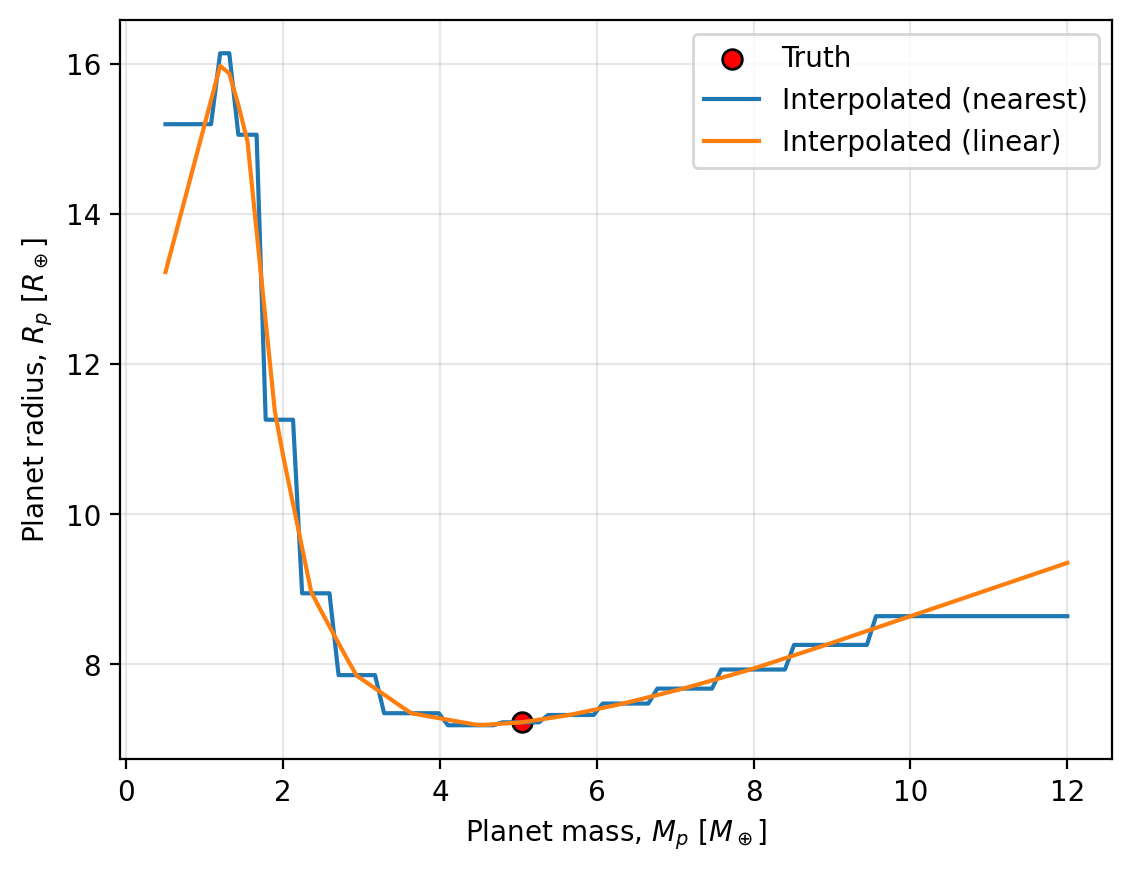

In [11]:

fig,ax = plt.subplots(1,1)

idx = 100_000
eval_loc = {k: gr.data[k].values[idx] for k in gr.input_keys}

val_tru = ia.util.undimen(gr.data["r_phot"].values[idx],"r_phot")
ax.scatter(eval_loc["mass_tot"], val_tru, s=50, c='r', label="Truth", edgecolors='k')

for method in ("nearest","linear",):

    mass_arr = np.linspace(0.5, 12, 100)
    val_est = []
    for mass in mass_arr:
        eval_loc["mass_tot"] = mass
        val_est.append(gr.interp_eval(eval_loc, method=method))
    # val_est = ia.util.redimen(val_est, "r_phot")

    ax.plot(mass_arr, val_est, label=f"Interpolated ({method})")

ax.set(xlabel=ia.util.varprops["mass_tot"].label, ylabel=ia.util.varprops["r_phot"].label)
ax.legend()
ax.grid(zorder=-2, alpha=0.3)

plt.show()

### Test across masses, and other dimension

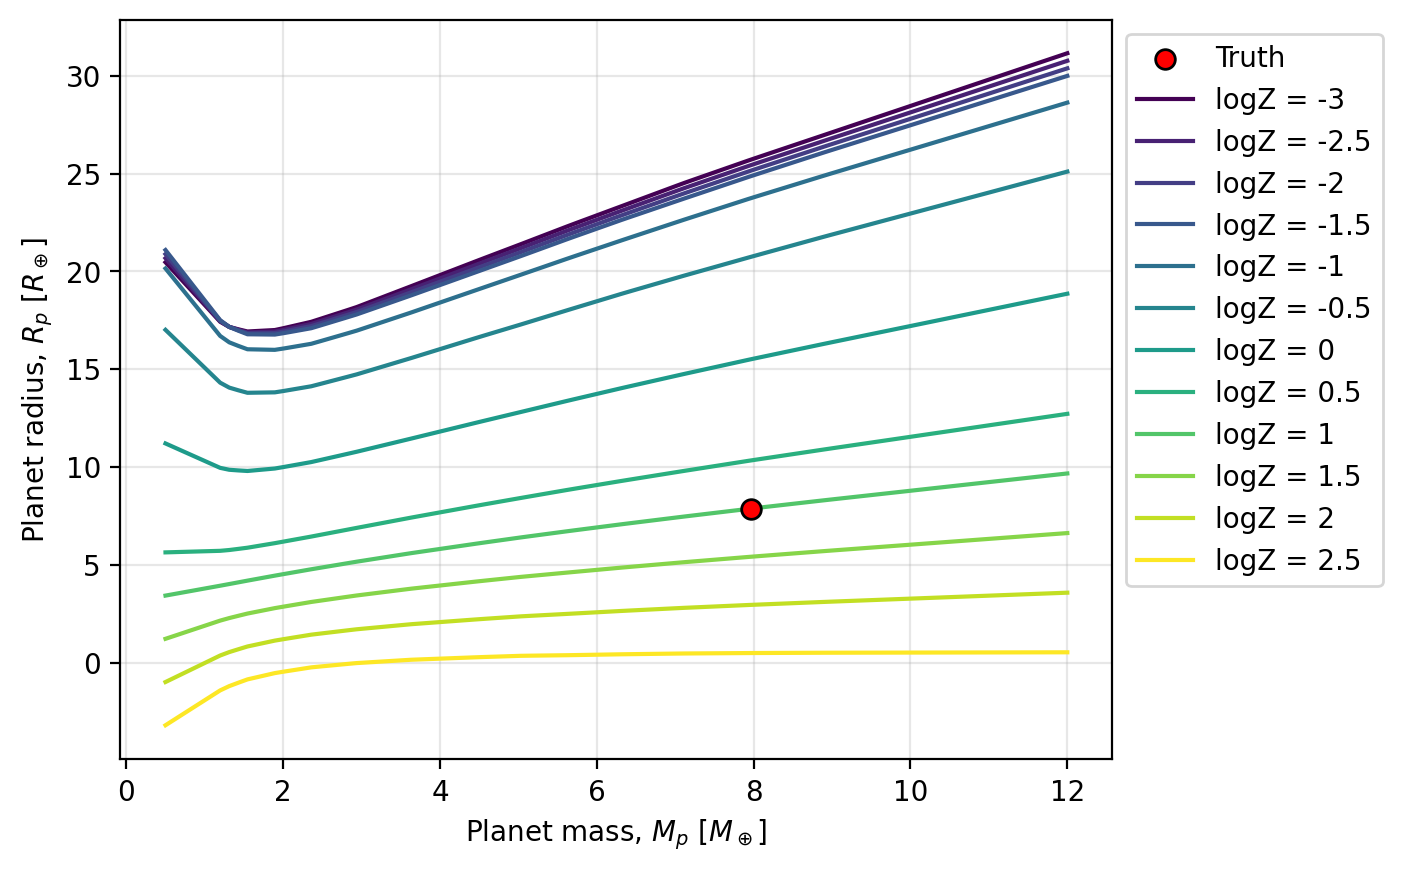

In [13]:

fig,ax = plt.subplots(1,1)

idx = 1000
eval_loc = {k: gr.data[k].values[idx] for k in gr.input_keys}

val_tru = ia.util.undimen(gr.data["r_phot"].values[idx], "r_phot")
ax.scatter(eval_loc["mass_tot"], val_tru, s=50, c='r', label="Truth", edgecolors='k', zorder=20)

z_key = "logZ"; z_arr = np.arange(-3, 3, 0.5)
norm = mpl.colors.Normalize(vmin=np.amin(z_arr), vmax=np.amax(z_arr), clip=True)
sm = mpl.cm.ScalarMappable(norm=norm, cmap='viridis')

for z in z_arr:

    mass_arr = np.linspace(0.5, 12, 100)
    val_est = []
    for mass in mass_arr:
        eval_loc["mass_tot"] = mass
        eval_loc[z_key] = z
        val_est.append(gr.interp_eval(eval_loc))

    ax.plot(mass_arr, val_est, label=f"{z_key} = {z:g}", c=sm.to_rgba(z), zorder=10)

ax.set(xlabel=ia.util.varprops["mass_tot"].label, ylabel=ia.util.varprops["r_phot"].label)
ax.legend(loc='upper left', bbox_to_anchor=(1,1))
ax.grid(zorder=-2, alpha=0.3)

plt.show()